In [ ]:
# Here we implement the GCN LSTM model
# To run this, please make sure your python version is >=3.6 and <3.9
# also make sure you have gpu and is tensorflow compatible

In [1]:
# run this to check your python version
import sys
sys.version

'3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) \n[GCC 7.5.0]'

In [2]:
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

/home/ubuntu/anaconda3/envs/myenvi/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from stellargraph.layer import GCN_LSTM

In [4]:
# run this to check if you have gpu
!nvidia-smi

Tue May  7 20:41:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10                     On  | 00000000:08:00.0 Off |                  Off |
|  0%   30C    P8              15W / 150W |      7MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import stellargraph as sg

In [18]:
!pwd

/home/ubuntu


In [5]:
import requests

import os
import math
import numpy as np
import pandas as pd
from itertools import product

import json
import time

In [6]:
# make sure you have the following file under your path
f = open('SF.json')
sf_data = json.load(f)

f = open('Fresno.json')
fresno_data = json.load(f)

f = open('PalmSpring.json')
palm_spring_data = json.load(f)

In [7]:
sf_data = [(x['time'], float(x['temp'])) for x in sf_data]

In [8]:
ps_data = []
for i in range(len(palm_spring_data)):
  if palm_spring_data[i]['temp'] is not None:
    ps_data.append((palm_spring_data[i]['time'], float(palm_spring_data[i]['temp'])))
  else:
    ps_data.append((palm_spring_data[i]['time'], None))

In [9]:
f_data = []
for i in range(len(fresno_data)):
  if fresno_data[i]['temp'] is not None:
    f_data.append((fresno_data[i]['time'], float(fresno_data[i]['temp'])))
  else:
    f_data.append((fresno_data[i]['time'], None))

In [10]:
ps_df = pd.DataFrame(ps_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
ps_df['DateTime'] = pd.to_datetime(ps_df['DateTime'])

# Step 3: Set 'DateTime' as the index
ps_df.set_index('DateTime', inplace=True)

# Step 4: Replace None values with the previous value (forward fill)
ps_df['Temperature'].fillna(method='ffill', inplace=True)
ps_df

,Temperature
DateTime,
2020-01-01 00:00:00,NaN
2020-01-01 01:00:00,17.8
2020-01-01 02:00:00,16.7
2020-01-01 03:00:00,15.6
2020-01-01 04:00:00,13.9
...,...
2022-12-31 19:00:00,12.8
2022-12-31 20:00:00,12.8
2022-12-31 21:00:00,13.9


In [11]:
fresno_df = pd.DataFrame(f_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
fresno_df['DateTime'] = pd.to_datetime(fresno_df['DateTime'])

# Step 3: Set 'DateTime' as the index
fresno_df.set_index('DateTime', inplace=True)

# Step 4: Replace None values with the previous value (forward fill)
fresno_df['Temperature'].fillna(method='ffill', inplace=True)
fresno_df

,Temperature
DateTime,
2020-01-01 00:00:00,NaN
2020-01-01 01:00:00,NaN
2020-01-01 02:00:00,NaN
2020-01-01 03:00:00,NaN
2020-01-01 04:00:00,NaN
...,...
2022-12-31 19:00:00,15.0
2022-12-31 20:00:00,15.1
2022-12-31 21:00:00,14.4


In [12]:
sf_df = pd.DataFrame(sf_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
sf_df['DateTime'] = pd.to_datetime(sf_df['DateTime'])

# Step 3: Set 'DateTime' as the index
sf_df.set_index('DateTime', inplace=True)

# Step 4: Replace None values with the previous value (forward fill)
sf_df['Temperature'].fillna(method='ffill', inplace=True)
sf_df

,Temperature
DateTime,
2020-01-01 00:00:00,15.0
2020-01-01 01:00:00,15.0
2020-01-01 02:00:00,12.2
2020-01-01 03:00:00,10.0
2020-01-01 04:00:00,10.0
...,...
2022-12-31 19:00:00,12.8
2022-12-31 20:00:00,12.2
2022-12-31 21:00:00,11.1


In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
sf_df['Temperature'] = scaler.fit_transform(sf_df['Temperature'].values.reshape(-1, 1))

In [15]:
fresno_df['Temperature'] = scaler.fit_transform(fresno_df['Temperature'].values.reshape(-1, 1))
ps_df['Temperature'] = scaler.fit_transform(ps_df['Temperature'].values.reshape(-1, 1))

In [29]:
combined_df = ps_df.join(fresno_df, how='outer', lsuffix='_ps', rsuffix='_fresno')
combined_df = combined_df.join(sf_df, how='outer', lsuffix='', rsuffix='_sf')
combined_df['Temperature_ps'] = combined_df['Temperature_ps'].fillna(method='bfill', inplace=False)
combined_df['Temperature_fresno'] = combined_df['Temperature_fresno'].fillna(method='bfill', inplace=False)

In [30]:
combined_df = combined_df.to_numpy()

In [209]:
# Define the split point for training and testing data
test_size = 24 * 30  # 30 days
train_data = combined_df[:-test_size]
test_data = combined_df[-test_size:]

# Function to create sequences
def create_sequences(data, input_length, prediction_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - prediction_length + 1):
        x = data[i:i + input_length, :]
        y = data[i + input_length:i + input_length + prediction_length, :]  # Predict next 24 hours for last city - SF
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 48
prediction_length = 1
X_train, y_train = create_sequences(train_data, input_length, prediction_length)
X_test, y_test = create_sequences(test_data, input_length, prediction_length)

In [211]:
X_train = np.swapaxes(X_train,2,1)
y_train = np.swapaxes(y_train,2,1).squeeze(-1)
X_test = np.swapaxes(X_test,2,1)
y_test = np.swapaxes(y_test,2,1).squeeze(-1)

In [216]:
sf_to_ps = 427
sf_to_fresno = 162
ps_to_fresno = 272

# 0-sf, 1-ps, 2-fresno
adj_mat = np.array([[0,1/sf_to_ps,1/sf_to_fresno],[1/sf_to_ps,0,1/ps_to_fresno],[1/sf_to_fresno,1/ps_to_fresno,0]])

In [217]:
gcn_lstm = GCN_LSTM(
    seq_len=48,
    adj=adj_mat,
    gc_layer_sizes=[10, 3],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[32, 32],
    lstm_activations=["tanh", "tanh"],
)

/home/ubuntu/anaconda3/envs/myenvi/lib/python3.6/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


In [218]:
gcn_lstm

In [219]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [220]:
model = Model(inputs=x_input, outputs=x_output)

In [221]:
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

In [222]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 3, 48)]           0         
_________________________________________________________________
tf.expand_dims_18 (TFOpLambd (None, 3, 48, 1)          0         
_________________________________________________________________
reshape_54 (Reshape)         (None, 3, 48)             0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 3, 10)             492       
_________________________________________________________________
fixed_adjacency_graph_convol (None, 3, 3)              42        
_________________________________________________________________
reshape_55 (Reshape)         (None, 3, 3, 1)           0         
_________________________________________________________________
permute_18 (Permute)         (None, 3, 3, 1)           0  

In [223]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=1024,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/200
25/25 [==============================] - 3s 28ms/step - loss: 0.1572 - mae: 0.1572 - val_loss: 0.2544 - val_mae: 0.2544
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 0.1366 - mae: 0.1366 - val_loss: 0.1963 - val_mae: 0.1963
Epoch 3/200
25/25 [==============================] - 0s 9ms/step - loss: 0.1056 - mae: 0.1056 - val_loss: 0.0789 - val_mae: 0.0789
Epoch 4/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0772 - mae: 0.0772 - val_loss: 0.0758 - val_mae: 0.0758
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0705 - mae: 0.0705 - val_loss: 0.0689 - val_mae: 0.0689
Epoch 6/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0640 - val_mae: 0.0640
Epoch 7/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0666 - mae: 0.0666 - val_loss: 0.0611 - val_mae: 0.0611
Epoch 8/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0654 -

In [224]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.030395185574889183 
Test loss: 0.01906997337937355


In [225]:
yhat = model.predict(X_test)

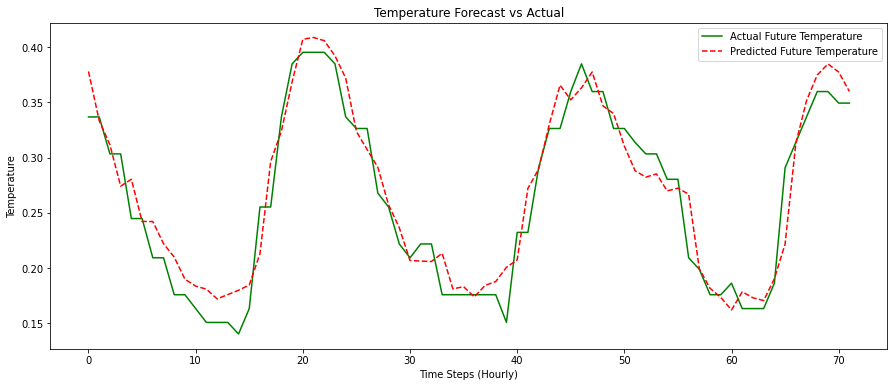

In [228]:
# Plotting the results for 72 hours
plt.figure(figsize=(15, 6))
# plt.plot(range(48), past, label='Actual Temperature')
plt.plot(range(0, 72), y_test[:72, 0], label='Actual Future Temperature', color='green')
plt.plot(range(0, 72), yhat[:72, 0], label='Predicted Future Temperature', linestyle='--', color='red')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Time Steps (Hourly)')
plt.ylabel('Temperature')
plt.legend()
plt.show()

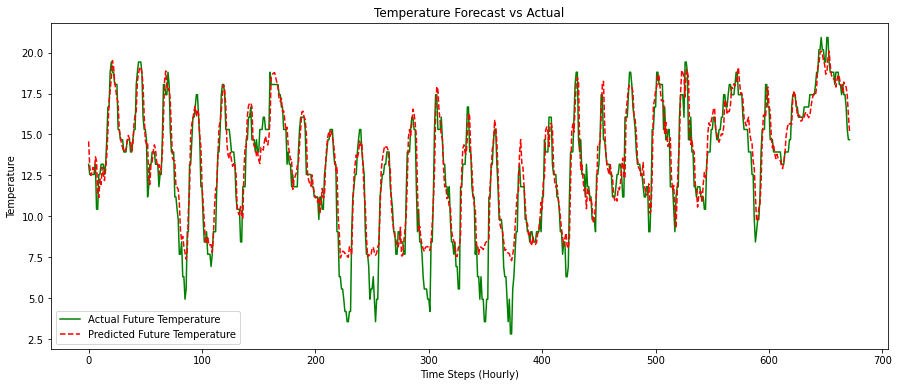

In [229]:
# plotting everything
# Inverse transform
actual = scaler.inverse_transform(y_test[:,2].reshape(-1,1))
predicted = scaler.inverse_transform(yhat[:,2].reshape(-1,1))
# past = scaler.inverse_transform(seq.numpy().reshape(-1, 1))

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(15, 6))
# plt.plot(range(48), past, label='Actual Temperature')
plt.plot(range(0, 672), actual, label='Actual Future Temperature', color='green')
plt.plot(range(0, 672), predicted, label='Predicted Future Temperature', linestyle='--', color='red')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Time Steps (Hourly)')
plt.ylabel('Temperature')
plt.legend()
plt.show()